In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.neighbors import KNeighborsClassifier
from google.colab import files
from math import *
import time
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


In [3]:
from google.colab import files

## Faça upload de um dataset com nome insurance (baixável em https://www.kaggle.com/mirichoi0218/insurance)
uploaded = files.upload()

Saving winequality.csv to winequality.csv


## Explorando um pouco o dataset

In [4]:
wine = pd.read_csv('/content/winequality.csv')
wine.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6,1
1,1,8.2,1.00,0.09,2.3,0.065,7.0,37.0,0.99685,3.32,0.55,9.0,6,1
2,2,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.99420,3.01,0.98,10.5,6,0
3,3,6.6,0.23,0.26,1.3,0.045,16.0,128.0,0.99340,3.36,0.60,10.0,6,0
4,4,7.2,0.24,0.29,3.0,0.036,17.0,117.0,0.99411,3.36,0.68,10.1,6,0


À primeira vista parece que o sistema que queremos é um que seja capaz de prever que tipo de vinho temos ao final (vermelho ou nao) a partir de diversas características. Vamos entender melhor o dataset

In [5]:
wine.describe()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,3248.000000,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1875.666681,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,1624.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,3248.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,4872.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,6496.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [6]:
wine['quality'].unique()

array([6, 7, 5, 4, 8, 3, 9])

In [7]:
wine['wine_is_red'].unique()

array([1, 0])

Certo, então a priori parece possível a previsão de duas características do vinho. Qualidade, pois há sete classes, e se é vermelho ou não. Nesse caso vamos começar tentando prever se o vinho é vermelho. Abaixo eu dropei a coluna Unnamed (pois é irrelevante para a nossa análise e portanto detrimental). Usando a técnica PCA também reduzi o modelo para duas dimensões para ver se de fato há uma divisão clara espacial (do período anterior foi visto que os datasets podem estar distribuídos das mais diversas maneiras).

In [8]:
def scales(df):
  df.columns
  notObject = df.columns[df.dtypes!='object']
  #df[notObject]
  for name in notObject:
    df[name] = (df[name]-df[name].min())/(df[name].max()-df[name].min())
  return df


In [9]:
wine = wine.drop(columns = ['Unnamed: 0'])
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6,1
1,8.2,1.00,0.09,2.3,0.065,7.0,37.0,0.99685,3.32,0.55,9.0,6,1
2,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.99420,3.01,0.98,10.5,6,0
3,6.6,0.23,0.26,1.3,0.045,16.0,128.0,0.99340,3.36,0.60,10.0,6,0
4,7.2,0.24,0.29,3.0,0.036,17.0,117.0,0.99411,3.36,0.68,10.1,6,0


In [10]:
wineN = wine.drop(columns = ['wine_is_red'])

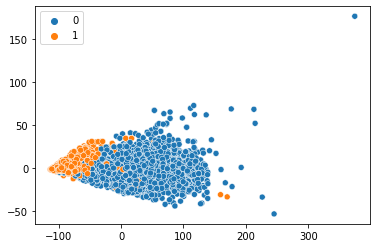

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
wineNew_PCA = pca.fit_transform(wineN)
sns.scatterplot(x = wineNew_PCA[:,0], y = wineNew_PCA[:,1], hue = wine['wine_is_red'].values, data = wineNew_PCA)

In [12]:
pca.explained_variance_ratio_

array([0.95355286, 0.04062238])

Vemos no scatterplot que em sua grande maioria há duas áreas bem distintas, com 2 outliers de valor 1

A linha abaixo normaliza o dataset para que não haja um viés devido a features muito dominantes

In [13]:
wine2 = scales(wine.copy())
wine2.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0.173554,0.353333,0.048193,0.023006,0.102990,0.052083,0.041475,0.128205,0.651163,0.308989,0.449275,0.5,1.0
1,0.363636,0.613333,0.054217,0.026074,0.093023,0.020833,0.071429,0.187777,0.465116,0.185393,0.144928,0.5,1.0
2,0.214876,0.106667,0.295181,0.079755,0.073090,0.083333,0.262673,0.136688,0.224806,0.426966,0.362319,0.5,0.0
3,0.231405,0.100000,0.156627,0.010736,0.059801,0.052083,0.281106,0.121265,0.496124,0.213483,0.289855,0.5,0.0
4,0.280992,0.106667,0.174699,0.036810,0.044850,0.055556,0.255760,0.134953,0.496124,0.258427,0.304348,0.5,0.0


## Divisão do dataset em treino e teste

Vamos fazer um train_test_split manual. Para isso, conforme explicado na playlist sobre tópicos em machine learning, basta randomizar as amostras e depois tomar uma percentagem específica

In [14]:
def ttsplit(df, labelColumn, ratio = 0.2):
  shuffled = df.sample(frac=1)
  shuffled.head()
  size = np.shape(shuffled)
  train = shuffled[:round((1-ratio)*size[0])]
  test = shuffled[round((1-ratio)*size[0]):]
  X_train = train.drop(columns = labelColumn).reset_index( drop = True)
  X_test = test.drop(columns = labelColumn).reset_index(drop = True)
  y_train = train[labelColumn].reset_index( drop = True)
  y_test = test[labelColumn].reset_index(drop = True)
  return X_train, X_test, y_train, y_test


In [15]:
init = time.time()
X_train, X_test, y_train, y_test = ttsplit(wine2, 'wine_is_red')
#np.shape(y_train)
print(time.time()-init)
X_test.head()

0.010364294052124023


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.280992,0.120000,0.156627,0.185583,0.044850,0.166667,0.479263,0.221515,0.534884,0.157303,0.289855,0.500000
1,0.578512,0.246667,0.198795,0.029141,0.149502,0.065972,0.073733,0.213418,0.403101,0.275281,0.405797,0.333333
2,0.272727,0.106667,0.246988,0.263804,0.061462,0.131944,0.320276,0.244650,0.465116,0.095506,0.101449,0.333333
3,0.743802,0.356667,0.397590,0.079755,0.122924,0.020833,0.082949,0.290920,0.271318,0.286517,0.289855,0.666667
4,0.181818,0.166667,0.228916,0.139571,0.051495,0.097222,0.271889,0.159823,0.581395,0.146067,0.434783,0.500000


## Implementando o KNN

A função abaixo retorna os índices no dataframe dos k vizinhos mais próximos


In [16]:
def neighbours (X_train, x, k = 5):
  dist = np.sqrt(np.sum((X_train-x)**2, axis=1)) 
  neigh = np.argsort(dist)[0:k]
  return neigh.values

In [17]:
neighbours(X_train, X_test.iloc[0])

array([3525, 2527, 4946, 2188, 1522])

In [18]:
def kNN(point, dataset, labels,k = 5):
  nn = neighbours(dataset, point)
  #print(nn , '\n')
  votes = labels.iloc[nn]
  #print(votes , '\n')
  counts = np.bincount(votes)
  #print(counts , '\n')
  return np.argmax(counts)

## Caso binário

A função runkNN roda o kNN em todo o test set para ver sua acurácia. O primeiro valor printado é o tempo de execução e o segundo a acurácia do modelo

In [19]:
def runkNN(X_train, X_test, y_train, y_test, k = 5):
  results = []
  R,C = np.shape(X_test)
  init = time.time()
  for i in range(R):
    results.append(kNN(X_test.iloc[i], X_train, y_train,k))
  print(time.time()-init)
  N = np.shape(y_test)
  accuracy = (y_test == results).sum() / N
  return accuracy

In [20]:
runkNN (X_train, X_test, y_train, y_test)

2.9569895267486572


array([0.98691301])

Vemos que a acurácia é de 99% em média. Vamos comparar com a acurácia do kNN nativo ao sklearn

In [21]:
model = KNeighborsClassifier(n_neighbors=5)
init = time.time()
model.fit(X_train,y_train)
y_pred= model.predict(X_test) 
print(time.time()-init)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

0.11864185333251953
Accuracy: 0.9869130100076983


## KNN com múltiplos labels

In [22]:
wine2['quality'] = wine['quality']
X_train, X_test, y_train, y_test = ttsplit(wine2, 'quality')
wine2.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0.173554,0.353333,0.048193,0.023006,0.102990,0.052083,0.041475,0.128205,0.651163,0.308989,0.449275,6,1.0
1,0.363636,0.613333,0.054217,0.026074,0.093023,0.020833,0.071429,0.187777,0.465116,0.185393,0.144928,6,1.0
2,0.214876,0.106667,0.295181,0.079755,0.073090,0.083333,0.262673,0.136688,0.224806,0.426966,0.362319,6,0.0
3,0.231405,0.100000,0.156627,0.010736,0.059801,0.052083,0.281106,0.121265,0.496124,0.213483,0.289855,6,0.0
4,0.280992,0.106667,0.174699,0.036810,0.044850,0.055556,0.255760,0.134953,0.496124,0.258427,0.304348,6,0.0


As duas linhas de código abaixo foram escritas para ver se o dataset estava funcionando bem com instâncias específicas.

In [23]:
y_train.head()

0    7
1    5
2    6
3    6
4    6
Name: quality, dtype: int64

In [24]:
runkNN (X_train, X_test, y_train, y_test)

2.8705615997314453


array([0.55966128])

In [25]:
model = KNeighborsClassifier(n_neighbors=5)
init = time.time()
model.fit(X_train,y_train)
y_pred= model.predict(X_test) 
print(time.time()-init)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

0.11680245399475098
Accuracy: 0.5596612779060816


Como podemos ver, a acurácia não é particularmente boa. Isso se deve ao fato, como podemos ver no gráfico abaixo, que não há uma clara divisão espacial entre as classes. De fato, parece um caso que a expertise do profissional não é tão facilmente substituída assim.

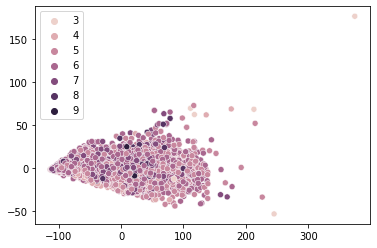

In [26]:
wineNew_PCA = pca.fit_transform(wine.drop(columns = ['quality']))
sns.scatterplot(x = wineNew_PCA[:,0], y = wineNew_PCA[:,1], hue = wine2['quality'].values, data = wineNew_PCA)

## Random forest: Determinando a importância das features

Artigo base https://vitalflux.com/feature-importance-random-forest-classifier-python/:

In [64]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [28]:
importances = forest.feature_importances_
importances

array([0.07724415, 0.10296484, 0.07954892, 0.08325332, 0.0843949 ,
       0.0862024 , 0.0915709 , 0.09855003, 0.08186871, 0.08643598,
       0.12419084, 0.003775  ])

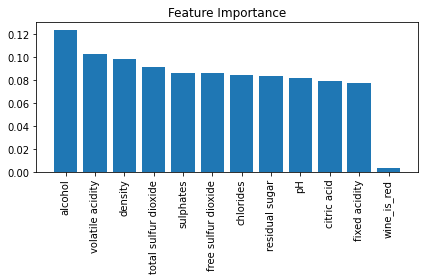

In [29]:
sorted_indices = np.argsort(importances)[::-1]
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Acima podemos ver que a característica mais importante para determinar a qualidade de um vinho é seu teor alcóolico, contando por mais de 12% da influência. O que tem menos influência é se o vinho é tinto ou não.

In [66]:
y_pred= forest.predict(X_test) 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6859122401847575


Observe que a acurácia de random forests é de cerca de 68%, 12% a mais que os 56% do knn

## Efeito da normalização

Os ensaios acima consideraram valores normalizados para features. Vamos ver o que acontece caso não normalizemos

In [30]:
X_train, X_test, y_train, y_test = ttsplit(wine, 'wine_is_red')


In [31]:
runkNN(X_train, X_test, y_train, y_test)

3.6990513801574707


array([0.94457275])

In [32]:
X_train, X_test, y_train, y_test = ttsplit(wine, 'quality')


In [33]:
runkNN(X_train, X_test, y_train, y_test)

3.754047155380249


array([0.46420323])

Há uma leve diminuição de acurácia. No caso binário desce de 98-99% para 91-92% e no não binário desce de 56-57% para 47-48%. Isso é o experado

##Sampling

No nosso caso, temos um dataset levemente enviesado, como podemos ver abaixo

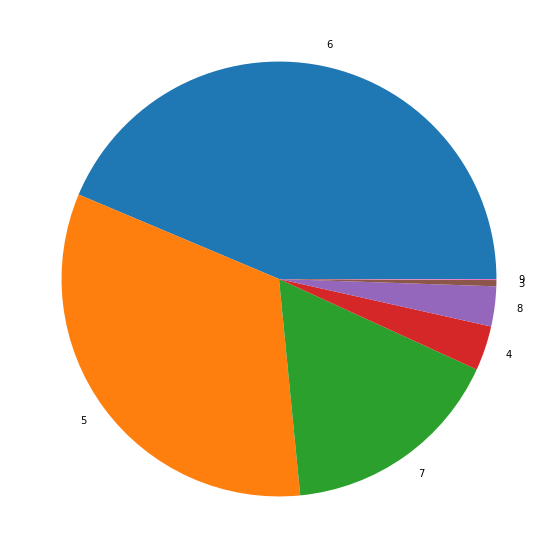

In [34]:
plt.figure(figsize=(10,10))
wine['quality'].value_counts()
plt.pie(wine['quality'].value_counts(), labels = wine['quality'].value_counts().index)
plt.show()

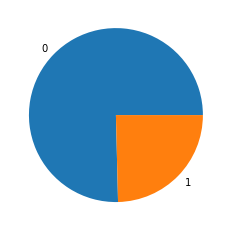

In [35]:
#plt.figure(figsize=(10,10))
wine['wine_is_red'].value_counts()
plt.pie(wine['wine_is_red'].value_counts(), labels = wine['wine_is_red'].value_counts().index)
plt.show()

Há uma discrepância de cerca de 3 para 1 no caso do wine is red, mas uma discrepância enorme entre os valores para qualidade, onde cerca de 80% dos valores são 5 ou 6. Esse desbalanceamento potencialmente influenciou os resultados de acurácia que tivemos antes. Abaixo vou utilizar por base o vídeo proposto --> https://www.youtube.com/watch?v=JnlM4yLFNuo e artigo https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf#:~:text=An%20approach%20to%20combat%20this%20challenge%20is%20Random,oversampling%20and%20undersampling%20involve%20introducing%20a%20bias%20

In [36]:
wine2 = scales(wine.copy())
wine2.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0.173554,0.353333,0.048193,0.023006,0.102990,0.052083,0.041475,0.128205,0.651163,0.308989,0.449275,0.5,1.0
1,0.363636,0.613333,0.054217,0.026074,0.093023,0.020833,0.071429,0.187777,0.465116,0.185393,0.144928,0.5,1.0
2,0.214876,0.106667,0.295181,0.079755,0.073090,0.083333,0.262673,0.136688,0.224806,0.426966,0.362319,0.5,0.0
3,0.231405,0.100000,0.156627,0.010736,0.059801,0.052083,0.281106,0.121265,0.496124,0.213483,0.289855,0.5,0.0
4,0.280992,0.106667,0.174699,0.036810,0.044850,0.055556,0.255760,0.134953,0.496124,0.258427,0.304348,0.5,0.0


In [37]:

X_train, X_test, y_train, y_test = ttsplit(wine2, 'wine_is_red')

As funções abaixo de de RandomOverSampler e RandomUnderSampler permitem a melhor amostragem dos datasets de treino. Todos os valores de Over foram sobreamostrados e de Under foram subamostrados. O subscripto q significa qualidade.

In [38]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# instantiating the random over sampler 
Over = RandomOverSampler()
# resampling X, y
X_Over, y_Over = Over.fit_resample(X_train, y_train)
# new class distribution 
print(y_Over.value_counts())

0.0    3929
1.0    3929
Name: wine_is_red, dtype: int64


In [39]:
Under = RandomUnderSampler()
X_Under, y_Under = Under.fit_resample(X_train, y_train)
# new class distribution 
print(y_Under.value_counts())

0.0    1269
1.0    1269
Name: wine_is_red, dtype: int64


In [40]:
runkNN(X_Over, X_test,y_Over,y_test)

5.3267436027526855


array([0.98768283])

In [41]:
runkNN(X_Under, X_test,y_Under,y_test)

3.756348133087158


array([0.98460354])

Acima vemos que tanto a sobreamostragem quanto a subamostragem não influenciam muito na acurácia do modelo, que já é bem elevada.

Fazendo o mesmo para qualidade, temos


In [42]:
wine2['quality']=wine['quality']
wine2.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_is_red
0,0.173554,0.353333,0.048193,0.023006,0.102990,0.052083,0.041475,0.128205,0.651163,0.308989,0.449275,6,1.0
1,0.363636,0.613333,0.054217,0.026074,0.093023,0.020833,0.071429,0.187777,0.465116,0.185393,0.144928,6,1.0
2,0.214876,0.106667,0.295181,0.079755,0.073090,0.083333,0.262673,0.136688,0.224806,0.426966,0.362319,6,0.0
3,0.231405,0.100000,0.156627,0.010736,0.059801,0.052083,0.281106,0.121265,0.496124,0.213483,0.289855,6,0.0
4,0.280992,0.106667,0.174699,0.036810,0.044850,0.055556,0.255760,0.134953,0.496124,0.258427,0.304348,6,0.0


In [56]:

X_train, X_test, y_train, y_test = ttsplit(wine2, 'quality')

In [57]:
X_q_Over, y_q_Over = Over.fit_resample(X_train, y_train)
# new class distribution 
print(y_q_Over.value_counts())

5    2261
6    2261
8    2261
7    2261
4    2261
3    2261
9    2261
Name: quality, dtype: int64


In [58]:
X_q_Under, y_q_Under = Under.fit_resample(X_train, y_train)
# new class distribution 
print(y_q_Under.value_counts())

3    5
4    5
5    5
6    5
7    5
8    5
9    5
Name: quality, dtype: int64


In [59]:
runkNN(X_q_Over, X_test,y_q_Over,y_test)

7.920025825500488


array([0.50731332])

In [60]:
runkNN(X_q_Under, X_test,y_q_Under,y_test)

3.0140366554260254


array([0.21785989])

Aqui temos o contrário do caso anterior. Embora do caso de sobreamostragem não haja tanta perda de acurácia, no caso de subamostragem é uma perda enorma. Isso é claro quando olhamos que a subamostragem deixa apenas 4 ou 5 instâncias por amostra, o que claramente elimina informação demais para que seja útil



## Ensemble Learning

Há várias técnicas para Ensemble Learning. Bagging, boosting, stacking. Todas elas são fórmulas válidas, mas têm certa complexidade de compreensão, e isso não posso negar. Para o código abaixo, preferi me basear na abordagem Hands On proposta em https://www.datacamp.com/community/tutorials/ensemble-learning-python . Isso porque os exemplos em código ficam mais evidentes na minha percepção.

In [48]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



In [67]:
kfold = model_selection.KFold(n_splits=10)
tree = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=tree, n_estimators=num_trees)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6635278642359568


Uau, observe como temos uma melhoria de cerca de 10% (saindo de 56 para 66% em relação ao knn). No entanto, ainda ficamos atrás do random forest (em torno de 68%). A medida mais acurada quanto a melhoria que o BaggingClassifier produz só pode no entanto ser percebida comparando ao modelo base do Decision Tree. Se minha experiência com kNN e Random Forests aqui me ensinou algo, é que todos os modelos são relativamente semelhantes de serem utilizados

In [68]:
tree.fit(X_train, y_train.values.ravel())
y_pred= tree.predict(X_test) 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.6058506543494996


Vemos então uma melhoria da acurácia em cerca de 6%. Não é muito, mas é o que se esperaria com um modelo baseado em bagging. No mesmo artigo, encontrei códigos para o Adaboost e para voting, mas como a ideia aqui era apenas representar, preferi não fazer mais testes com isso.